<a href="https://colab.research.google.com/github/JhulianaM/Mammography/blob/master/UltimoVDSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paso 1: Subir el archivo kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhulianamercado","key":"a71185f6733aa19acf1b25c0137bd4ea"}'}

In [ ]:
# Paso 2: Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Paso 3: Descargar el Dataset de Kaggle
!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip -d mias-mammography

Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 96% 298M/312M [00:03<00:00, 79.2MB/s]
100% 312M/312M [00:03<00:00, 81.9MB/s]
Archive:  mias-mammography.zip
  inflating: mias-mammography/Info.txt  
  inflating: mias-mammography/all-mias.tar.gz  
  inflating: mias-mammography/all-mias/Info.txt  
  inflating: mias-mammography/all-mias/Licence.txt  
  inflating: mias-mammography/all-mias/README  
  inflating: mias-mammography/all-mias/mdb001.pgm  
  inflating: mias-mammography/all-mias/mdb002.pgm  
  inflating: mias-mammography/all-mias/mdb003.pgm  
  inflating: mias-mammography/all-mias/mdb004.pgm  
  inflating: mias-mammography/all-mias/mdb005.pgm  
  inflating: mias-mammography/all-mias/mdb006.pgm  
  inflating: mias-mammography/all-mias/mdb007.pgm  
  inflating: mias-mammography/all-mias/mdb008.pgm  
  inflating: mias-mammography/all-mias/mdb009.pgm  
  inflating: mias-mammography/all-mias/mdb010.pgm  
  inflating: mias-mammography/all-mias/mdb01

In [ ]:
# Instalación de paquetes necesarios
!pip install tensorflow tensorflow-addons h5py kaggle opencv-python

import os
import numpy as np
import cv2
import h5py
#import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import cv2
import os
from glob import glob

Total images loaded: 322


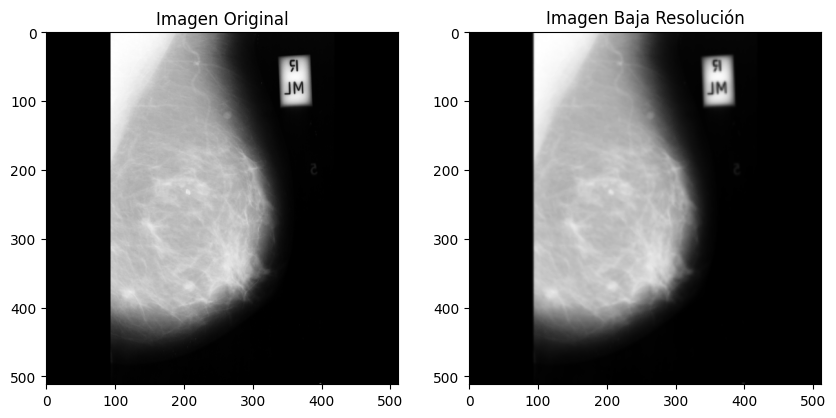

In [ ]:
# Paso 5: Funciones para Leer y Preprocesar Imágenes
def load_mias_images(path):
    image_files = glob(os.path.join(path, '*.pgm'))
    images = []
    for file in image_files:
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
    return images

def preprocess_image(image, scale):
    h, w = image.shape
    low_res = resize(image, (h // scale, w // scale), anti_aliasing=True)
    low_res = resize(low_res, (h, w), anti_aliasing=True)
    return low_res

mias_images = load_mias_images('mias-mammography/all-mias')
print(f"Total images loaded: {len(mias_images)}")

# Preprocess a sample image
sample_image = mias_images[0]
sample_image = resize(sample_image, (512, 512), anti_aliasing=True)
low_res_sample = preprocess_image(sample_image, scale=2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(sample_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Imagen Baja Resolución")
plt.imshow(low_res_sample, cmap='gray')
plt.show()


In [ ]:
# Paso 6: Definir el Modelo VDSR
def VDSR(input_shape=(None, None, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    for _ in range(18):
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    outputs = Add()([x, inputs])
    model = Model(inputs, outputs)
    return model

model = VDSR()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 64)       36928     ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
# Paso 7: Generar Datos de Entrenamiento
def generate_training_data(images, scale, patch_size=32, num_patches_per_image=100):
    patches = []
    for image in images:
        h, w = image.shape
        for _ in range(num_patches_per_image):
            x = np.random.randint(0, h - patch_size)
            y = np.random.randint(0, w - patch_size)
            patch = image[x:x + patch_size, y:y + patch_size]
            low_res_patch = preprocess_image(patch, scale)
            patches.append((low_res_patch, patch))
    return patches

patches = generate_training_data(mias_images, scale=2)

x_train = np.array([p[0] for p in patches]).reshape(-1, 32, 32, 1)
y_train = np.array([p[1] for p in patches]).reshape(-1, 32, 32, 1)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (32200, 32, 32, 1)
y_train shape: (32200, 32, 32, 1)


data augmentation

In [ ]:
# Paso 8: Entrenar el Modelo
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
1610/1610 [==============================] - 41s 20ms/step - loss: 436.6673 - val_loss: 7.8391
Epoch 2/50
1610/1610 [==============================] - 36s 22ms/step - loss: 65.2024 - val_loss: 5.7426
Epoch 3/50
1610/1610 [==============================] - 32s 20ms/step - loss: 97.6304 - val_loss: 14.4611
Epoch 4/50
1610/1610 [==============================] - 33s 20ms/step - loss: 35.5686 - val_loss: 5.7142
Epoch 5/50
1610/1610 [==============================] - 33s 20ms/step - loss: 31.4100 - val_loss: 798.5288
Epoch 6/50
1610/1610 [==============================] - 34s 21ms/step - loss: 37.9269 - val_loss: 3.9236
Epoch 7/50
1610/1610 [==============================] - 34s 21ms/step - loss: 30.2332 - val_loss: 72.5026
Epoch 8/50
1610/1610 [==============================] - 33s 20ms/step - loss: 8.0932 - val_loss: 4.0266
Epoch 9/50
1610/1610 [==============================] - 32s 20ms/step - loss: 19.9571 - val_loss: 3.8384
Epoch 10/50
1610/1610 [============================

1/1 [==============================] - 0s 27ms/step


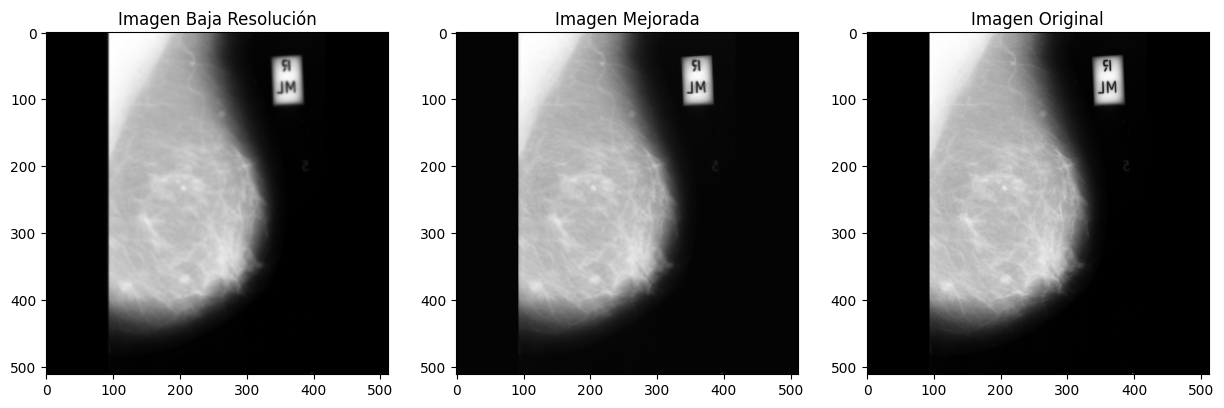

In [ ]:
# Paso 9: Evaluar el Modelo
low_res_sample_reshaped = low_res_sample.reshape(1, 512, 512, 1)
predicted_image = model.predict(low_res_sample_reshaped)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 3)
plt.title("Imagen Original")
plt.imshow(sample_image, cmap='gray')
plt.subplot(1, 3, 1)
plt.title("Imagen Baja Resolución")
plt.imshow(low_res_sample, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Imagen Mejorada")
plt.imshow(predicted_image[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
# Calcular PSNR y SSIM
print("PSNR:", psnr(sample_image, predicted_image[0, :, :, 0]))
print("SSIM:", ssim(sample_image, predicted_image[0, :, :, 0], data_range=predicted_image[0, :, :, 0].max() - predicted_image[0, :, :, 0].min()))

PSNR: -40.030963470719556
SSIM: 0.5048359067638497


<ipython-input-17-9e46b842a9bf>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("PSNR:", psnr(sample_image, predicted_image[0, :, :, 0]))


In [ ]:
# Paso 10: Guardar el Modelo
model.save('vdsr_ddsm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
